In [27]:
%matplotlib inline 

import six
import Quandl
import calendar
import math
import numpy as np
import pandas as pd
import seaborn as sb
import pylab as pylab
from datetime import datetime

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal
import statsmodels.api as sm 
import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, ensemble
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import preprocessing

import sys
from os import listdir
from os.path import isfile, join
from helpers import features_analysis, procces_stocks, data_manipulation, download_quandl_data, ml_dataset
from classes import Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')

In [82]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
OIL_BRENT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'OIL_BRENT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, OIL_BRENT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD_AM', 'USD', 'USD_AM', 'USD', 'Open', 'Open', 'Open', 'Open', 'Open']
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date']]
    #new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]    
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)
dataset = dataset.fillna(method='ffill')

In [83]:
def remove_columns_from_dataset(dataset, predicting='close', shifted = False):
    """
    """

    ###########################
    # predicting close price: #
    ###########################        
    colsToRemove = []
    colsToShift = []
    
    if predicting == 'close':
        if not shifted:        
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'GOLD' in col and not '_AM' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SILVER' in col and not '_USD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'OIL_BRENT' in col and not '_USD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'PLAT' in col and not '_AM' in col])
            colsToRemove.extend([col for col in dataset.columns if 'DJIA' in col and not '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'HSI' in col and '_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'IBEX' in col and not '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SP500' in col and not '_Open' in col])
            colsToRemove.remove('IBEX_RD_B1_Close')            
        else:
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])            
            colsToShift.extend([col for col in dataset.columns if 'GOLD' in col and not '_AM' in col])
            colsToShift.extend([col for col in dataset.columns if 'SILVER' in col and not '_USD' in col])
            colsToShift.extend([col for col in dataset.columns if 'OIL_BRENT' in col and not '_USD' in col])
            colsToShift.extend([col for col in dataset.columns if 'PLAT' in col and not '_AM' in col])
            colsToShift.extend([col for col in dataset.columns if 'DJIA' in col and not '_Open' in col])
            colsToShift.extend([col for col in dataset.columns if 'HSI' in col and '_Date' in col])
            colsToShift.extend([col for col in dataset.columns if 'IBEX' in col and not '_Open' in col])
            colsToShift.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToShift.extend([col for col in dataset.columns if 'SP500' in col and not '_Open' in col])
            
    ###########################
    # predicting open price: #
    ###########################

    if predicting == 'open' and not shifted:            
            colsToRemove.extend([col for col in dataset.columns if 'Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'GOLD' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SILVER' in col])
            colsToRemove.extend([col for col in dataset.columns if 'PLAT' in col])
            colsToRemove.extend([col for col in dataset.columns if 'OIL_BRENT' in col])    
            colsToRemove.extend([col for col in dataset.columns if 'DJIA' in col])
            colsToRemove.extend([col for col in dataset.columns if 'HSI' in col and '_Open' in col])
            colsToRemove.extend([col for col in dataset.columns if 'IBEX' in col])
            colsToRemove.extend([col for col in dataset.columns if 'N225' in col and'_Date' in col])
            colsToRemove.extend([col for col in dataset.columns if 'SP500' in col])
            colsToRemove.remove('IBEX_RD_B1_Open')

    colsToShift = list(set(colsToShift) - set(colsToRemove)) 
    df = dataset.drop(colsToRemove, axis = 1)
    if shifted: 
        df[colsToShift] = df[colsToShift].shift(1)
#        df = df.drop(dataset.index[-1,], axis=0)
    
    return df

def dataset_to_train_using_dates(dataset, trainDates, testDates, predicting = 'close', binary = False, shiftFeatures = False, shiftTarget = False):
    """
    
    Parameter
    ---------------------
    - dataset: dataframe containing all available columns for a set of dates
    - trainDates: list containing the start training day and end training day
    - testDates: list containing the start training day and end testing day
    - namesToRemove: partial names to search to remove those columns
    - colY: name of target
    - binary: boolean detemines whether features will be binary only 
    - shifted: boolean detemines whether rows will be shifted by one

    """
    
    if shiftFeatures == shiftTarget:
        raise ValueError("Features and Target cannot be shifted at the same time")
        
    dataset = remove_columns_from_dataset(dataset, shifted = shiftFeatures)


    ###########################
    # predicting close price: #
    ###########################    
    colY = ''
    colsToRemove = []

    if predicting == 'close': 
        colY = 'IBEX_RD_B1_Close'
        colsToRemove = ['IBEX_RD_B1_Close']
    if predicting == 'open': 
        colY = 'IBEX_RD_B1_Open'
        colsToRemove = ['IBEX_RD_B1_Close', 'IBEX_RD_B1_Open']

    train_df = dataset.iloc[trainDates[0]:trainDates[1]+1,]    
    test_df = dataset.iloc[testDates[0]:testDates[1]+1,]
        
    if binary:        
        colsToRemove.extend([col for col in dataset.columns if '_B' not in col])
        colsToRemove = list(set(colsToRemove))
        trainX = np.nan_to_num(np.asarray(train_df.drop(colsToRemove, axis = 1)))
        testX = np.nan_to_num(np.asarray(test_df.drop(colsToRemove, axis = 1)))        
    else:        
        colsToRemove = list(set(colsToRemove))
        trainX = np.nan_to_num(np.asarray(train_df.drop(colsToRemove, axis = 1)))
        testX = np.nan_to_num(np.asarray(test_df.drop(colsToRemove, axis = 1)))

    if shiftTarget:        
        trainY = np.nan_to_num(np.asarray(train_df[colY].shift(1)))[:]
        testY = np.nan_to_num(np.asarray(test_df[colY].shift(1)))[:]
        trainX = trainX[1:]
        testX = testX[1:]
    else:
        trainY = np.nan_to_num(np.asarray(train_df[colY]))
        testY = np.nan_to_num(np.asarray(test_df[colY]))

    columns_names = dataset.drop(colsToRemove, axis=1).columns.values

    return trainX, trainY, testX, testY, columns_names, dataset

In [84]:
training_dates = Iteration.Iteration('1993-08-19', '2012-07-06')
testing_dates  = Iteration.Iteration('2012-07-09', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)

trainX, trainY, testX, testY, cols, new_dataset = dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=True)

In [81]:
dataset.head(3)

,Date,GOLD_USD_AM,GOLD_USD_PM,GOLD_RD1_USD_AM,GOLD_RD_P1_USD_AM,GOLD_RD_B1_USD_AM,GOLD_RD3_USD_AM,GOLD_RD_P3_USD_AM,GOLD_RD_B3_USD_AM,GOLD_RD5_USD_AM,...,SP500_RD_B1_Adjusted Close,SP500_RD3_Adjusted Close,SP500_RD_P3_Adjusted Close,SP500_RD_B3_Adjusted Close,SP500_RD5_Adjusted Close,SP500_RD_P5_Adjusted Close,SP500_RD_B5_Adjusted Close,SP500_RD30_Adjusted Close,SP500_RD_P30_Adjusted Close,SP500_RD_B30_Adjusted Close
0,1993-08-19,373.65,373.40,0.80,0.214563,1,0.15,0.040161,1,-1.7,...,1,4.049988,0.895262,1,7.470002,1.663846,1,7.789978,1.736354,1
1,1993-08-20,370.35,373.25,-3.30,-0.883179,0,-2.15,-0.577181,0,-0.1,...,0,3.029999,0.668682,1,6.019989,1.337359,1,8.050019,1.796438,1
2,1993-08-23,373.60,373.10,3.25,0.877548,1,0.75,0.201153,1,0.1,...,0,-0.809998,-0.177616,0,2.850006,0.630003,1,6.250000,1.392044,1


In [80]:
new_dataset.head(3)

,GOLD_USD_AM,GOLD_USD_PM,GOLD_RD1_USD_AM,GOLD_RD_P1_USD_AM,GOLD_RD_B1_USD_AM,GOLD_RD3_USD_AM,GOLD_RD_P3_USD_AM,GOLD_RD_B3_USD_AM,GOLD_RD5_USD_AM,GOLD_RD_P5_USD_AM,...,SP500_RD_B1_Adjusted Close,SP500_RD3_Adjusted Close,SP500_RD_P3_Adjusted Close,SP500_RD_B3_Adjusted Close,SP500_RD5_Adjusted Close,SP500_RD_P5_Adjusted Close,SP500_RD_B5_Adjusted Close,SP500_RD30_Adjusted Close,SP500_RD_P30_Adjusted Close,SP500_RD_B30_Adjusted Close
0,373.65,373.25,0.80,0.214563,1,0.15,0.040161,1,-1.7,-0.452911,...,0.0,3.029999,0.668682,1.0,6.019989,1.337359,1.0,8.050019,1.796438,1.0
1,370.35,373.10,-3.30,-0.883179,0,-2.15,-0.577181,0,-0.1,-0.026994,...,0.0,-0.809998,-0.177616,0.0,2.850006,0.630003,1.0,6.250000,1.392044,1.0
2,373.60,373.65,3.25,0.877548,1,0.75,0.201153,1,0.1,0.026774,...,1.0,3.339996,0.731765,1.0,6.639984,1.465360,1.0,11.679993,2.606618,1.0


In [85]:
N_TREES = 500
SEED = 42


selected_models = [
    "LRC:dataset",    
    "RFC:dataset",
    "GBC:dataset"
    #"RFC:effects_f",  # experimental; added after the competition
]


# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC': linear_model.LogisticRegression,
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier}[model_id]()
    model.set_params(random_state=SEED)
    models.append(model)

clf = Stacking.Stacking(models, stack=True, fwls=False,
                           model_selection=True)

###  Metrics
print("computing cv score")
mean_auc = 0.0
iter_ = 1
for i in range(iter_):        
    cv_preds = clf.fit_predict(trainY, trainX, testX, testY, show_steps=True)

    fpr, tpr, _ = metrics.roc_curve(testY, cv_preds)
    roc_auc = metrics.auc(fpr, tpr)
    print "AUC (fold %d/%d): %.5f" % (i + 1, iter_, roc_auc)
    mean_auc += roc_auc

    print "Mean AUC: %.5f" % (mean_auc/iter_)


computing cv score
> AUC: 0.5230 (0.5230, 0.5229, 0.0000) [LR]
> AUC: 1.0000 (0.9939, 1.0000, 0.0000) [RFC]
> AUC: 1.0000 (1.0000, 1.0000, 0.0000) [GBC]
- best subset auc (1 models): 1.0000 > [1]
- best subset auc (2 models): 1.0000 > [1, 2]
best auc: 1.0000
best n: 1
best indices: [1]
> model: RandomForestClassifier 
> model: GradientBoostingClassifier 
AUC (fold 1/1): 1.00000
Mean AUC: 1.00000


In [100]:
cv_preds[cv_preds >= 0.5] = 1
ones = np.where(cv_preds == 1)
cv_preds[cv_preds < 0.5] = 0
zeros = np.where(cv_preds == 0)

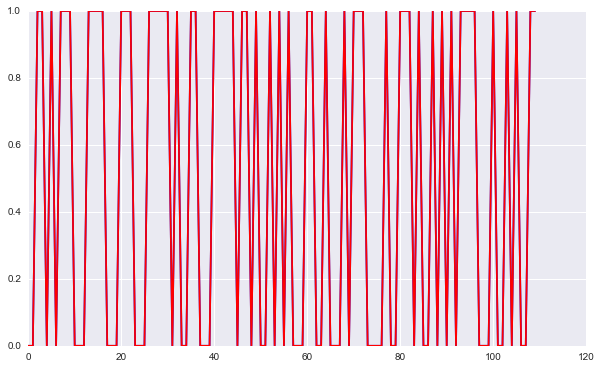

In [108]:
plt.figure()
plt.plot(cv_preds[0:110], c='blue')
plt.plot(testY[0:110], c='red')
plt.show()

compute_scores...
n_components pca...
n_components fa...
best n_components by PCA CV = 125
best n_components by FactorAnalysis CV = 115


NameError: name 'rank' is not defined

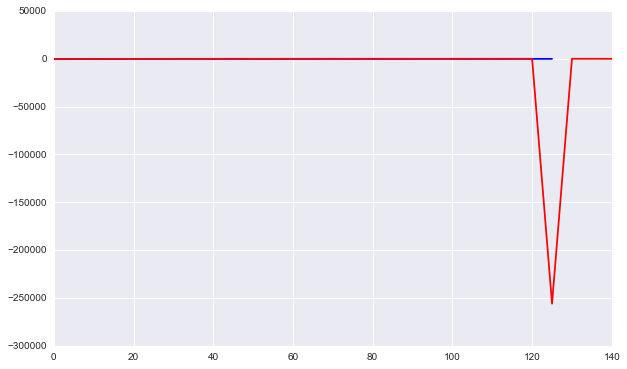

In [4]:
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

# Fit the models
n_features = trainX.shape[1]
n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = decomposition.PCA()
    fa = decomposition.FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

for X, title in [(trainX, 'Data')]:
    print "compute_scores..."
    pca_scores, fa_scores = compute_scores(X)
    print "n_components pca..."
    n_components_pca = n_components[np.argmax(pca_scores)]
    print "n_components fa..."    
    n_components_fa = n_components[np.argmax(fa_scores)]

#    pca = decomposition.PCA(n_components='mle')
#    pca.fit(X)
#    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
#    print("best n_components by PCA MLE = %d" % n_components_pca_mle)
#
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
#    plt.axvline(n_components_pca_mle, color='k',
#                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')
#
    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
#    plt.axhline(lw_score(X), color='orange',
#                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')
#
    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

In [33]:
#data_manipulation.write_csv_data(GOLD, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(OIL_BRENT, '/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')